# Setup

In [1]:
fine_tune_model = True
dataset_name = "EmoEvent (Raw)" # Name of the dataset to use. See config_files/dataset_config.py
include_unlabeled_labels = False    # True: Includes "others" or similar labels for records that did not fit specific classes.

# Reducing amount of real data per class by...
trim_type = None     # Options: "ratio", "value", or None
trim_to_ratio = 0.10
trim_to_value = 25

# Classifier Settings
classifier = "roberta"
model = "roberta-base"
epochs = 2

# Randomization Seed Values
train_test_random_seed = 42
trim_random_seed = 42
shuffle_random_seed = 42
classifier_random_seed = 42

# Imports
## Libraries

In [2]:
import torch

print("CUDA Enabled? " + str(torch.cuda.is_available())) 
if torch.cuda.is_available():
    print("Device: " + torch.cuda.get_device_name())

CUDA Enabled? True
Device: NVIDIA GeForce RTX 3080 Ti


## Config Files

In [3]:
from config_files import dataset_config

# Workflow
## Real Data

In [4]:
dataset_metadata = dataset_config.dataset[dataset_name]

### Loading

In [5]:
import pandas as pd

df_real = pd.DataFrame([])

if dataset_metadata["location"] == "local":
            
    if dataset_metadata["filetype"] == "csv":
        df_real = pd.read_csv(dataset_metadata["abspath"])
    
    elif dataset_metadata["filetype"] == "tsv":
        df_real = pd.read_csv(dataset_metadata["abspath"], sep="\t")
        
df_real

,id,event,tweet,offensive,emotion
0,3B9XR6P1WE1U78OX08FW8NXJL93BJG,NotreDame,I know that the Notre Dame is a very important...,NO,others
1,3P4ZBJFX2V96Q90CC9K7G3IC235WFF,Venezuela,#BREAKING: (USER) -- Trump threatens `full an...,NO,others
2,3IQ9O0AYW65Y8JY8ICLHWGO5E1JIT6,LaLiga,#Barcelona will win La Liga with three games t...,NO,others
3,3XEIP58NL0TWKWFD977CAKHEG1ZLZ3,LaLiga,HT: Decent half. A goal would've been good tho...,NO,others
4,3BFNCI9LYKWWKIJIK6BTNEUY6MU37E,GretaThunberg,In the 20th century we had weeping statues of ...,NO,others
...,...,...,...,...,...
7261,3TTPFEFXCTQSAQCCGHV3LUVCUGPH6X,Venezuela,With regime change yet to take hold in #Venezu...,NO,fear
7262,3XT3KXP24Z4S6LNWMZDOL6WRUT46IF,NotreDame,#NotreDameCathedralFire Fantastic the response...,NO,others
7263,3EHIMLB7F75FE4V09WS158R30BIH8M,GameOfThrones,For those of you questioning the Arya thing. P...,NO,others
7264,3MYASTQBG7H48SQU9UQB0EX52P7DQG,NotreDame,Respect for people in france who've lost a his...,NO,sadness


### Preprocessing

In [6]:
df_real.drop(columns = dataset_metadata["unused_columns"], inplace=True)
df_real.rename(columns = dataset_metadata["remap_columns"], inplace=True)

df_real

,text,labels
0,I know that the Notre Dame is a very important...,others
1,#BREAKING: (USER) -- Trump threatens `full an...,others
2,#Barcelona will win La Liga with three games t...,others
3,HT: Decent half. A goal would've been good tho...,others
4,In the 20th century we had weeping statues of ...,others
...,...,...
7261,With regime change yet to take hold in #Venezu...,fear
7262,#NotreDameCathedralFire Fantastic the response...,others
7263,For those of you questioning the Arya thing. P...,others
7264,Respect for people in france who've lost a his...,sadness


In [7]:
# Remove "Others"
if not include_unlabeled_labels:
    df_real.drop(df_real[df_real['labels'] == dataset_metadata["unlabeled_label"]].index, inplace=True)

df_real

,text,labels
8,USER People of #Venezuela !! so hilarious movi...,disgust
10,Remarkable match &amp; Incredible performance ...,joy
11,That episode of Game Of Thrones was not as gre...,anger
12,#AvengersEndGame may have had the visual and w...,joy
14,Lmao. Liverpool are done 😂. 🐐 Makes it 2-0 #U...,joy
...,...,...
7255,#WorldBookDay in words of #IvoAndric #NobelPri...,joy
7258,"Dear Politicians: Next election, you will want...",anger
7261,With regime change yet to take hold in #Venezu...,fear
7264,Respect for people in france who've lost a his...,sadness


### Train/Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_real['text'], 
                                                    df_real['labels'], 
                                                    stratify = df_real['labels'],
                                                    test_size=0.2, 
                                                    random_state=train_test_random_seed)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

df_train

(3186,) (3186,)
(797,) (797,)


,text,labels
22,👧 Who is #GretaThunberg? One of the world’s 10...,disgust
5225,Head up redmen. Played well tonight but footba...,joy
5501,#Breaking 》 USER sending a special message to ...,anger
1286,"As you can tell, I am thankful for what has su...",joy
4869,"USER This #coup will fail also, the #Venezuela...",sadness
...,...,...
1221,HAPPY #WORLDBOOKDAY FROM YOUR FAVORITE NEW YOR...,joy
5981,Just seen #GameofThrones 3rd episode. Great st...,joy
4516,Canny actually believe how good that episode o...,surprise
2125,FT: #Barcelona 1-0 #Levante. Leo #Messi (who e...,joy


### Trim Training Dataset

In [9]:
import numpy as np

if trim_type == "ratio":
    if trim_to_ratio < 1:
        
        real_label_balance =  pd.Series(df_train.labels).value_counts()
        new_label_balance = np.floor(real_label_balance * trim_to_ratio).astype(int)
        df_label_balance = pd.concat([real_label_balance, new_label_balance], axis=1)
        print(df_label_balance)
        
        for label, value in zip(new_label_balance.index, new_label_balance.values):
            # Get label records and trim to size
            df_label = df_train[df_train['labels'] == label]            
            df_label = df_label.sample(value, random_state = trim_random_seed)
            
            # Remove old label records and add back in trimmed sample
            df_train = df_train.drop(df_train[df_train['labels'] == label].index, axis = 0)
            df_train = pd.concat([df_train, df_label])
            
elif trim_type == "value":
    if trim_to_value > 0:
        
        real_label_balance = pd.Series(df_train.labels).value_counts()
        new_label_balance  = np.minimum(real_label_balance, trim_to_value)
        df_label_balance   = pd.concat([real_label_balance, new_label_balance], axis=1)
        print(df_label_balance)
        
        for label, value in zip(new_label_balance.index, new_label_balance.values):
            # Get label records and trim to size
            df_label = df_train[df_train['labels'] == label]            
            df_label = df_label.sample(value, random_state = trim_random_seed)
            
            # Remove old label records and add back in trimmed sample
            df_train = df_train.drop(df_train[df_train['labels'] == label].index, axis = 0)
            df_train = pd.concat([df_train, df_label])

df_train

,text,labels
22,👧 Who is #GretaThunberg? One of the world’s 10...,disgust
5225,Head up redmen. Played well tonight but footba...,joy
5501,#Breaking 》 USER sending a special message to ...,anger
1286,"As you can tell, I am thankful for what has su...",joy
4869,"USER This #coup will fail also, the #Venezuela...",sadness
...,...,...
1221,HAPPY #WORLDBOOKDAY FROM YOUR FAVORITE NEW YOR...,joy
5981,Just seen #GameofThrones 3rd episode. Great st...,joy
4516,Canny actually believe how good that episode o...,surprise
2125,FT: #Barcelona 1-0 #Levante. Leo #Messi (who e...,joy


### Shuffle Records

In [10]:
df_train = df_train.sample(frac = 1, random_state = shuffle_random_seed)

df_train

,text,labels
3946,USER USER Let's wait for the CIA controlled op...,disgust
4732,Wanting to put an end to humanity's destructio...,disgust
6197,Utterly unbelievable. Democrat 2020 candidates...,disgust
1790,USER USER_CA do guys not understand what your ...,disgust
4893,600 and one of his best … Magic from Messi #ba...,joy
...,...,...
6220,Some things are too important to ignore- preor...,joy
3057,"Today is #WorldBookDay, so make sure you celeb...",joy
6619,Happy #WorldBookDay 🤓🤓 (This is also the true ...,joy
6037,This digital scan of Notre Dame offers hope fo...,joy


In [11]:
num_labels = df_real["labels"].nunique()
label_names = df_real["labels"].unique()
print(f"{num_labels} : {label_names}")

6 : ['disgust' 'joy' 'anger' 'sadness' 'surprise' 'fear']


## Encode Labels

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df_train["labels"])

df_train["labels"] = le.transform(df_train["labels"])
df_test["labels"] = le.transform(df_test["labels"])

df_train

,text,labels
3946,USER USER Let's wait for the CIA controlled op...,1
4732,Wanting to put an end to humanity's destructio...,1
6197,Utterly unbelievable. Democrat 2020 candidates...,1
1790,USER USER_CA do guys not understand what your ...,1
4893,600 and one of his best … Magic from Messi #ba...,3
...,...,...
6220,Some things are too important to ignore- preor...,3
3057,"Today is #WorldBookDay, so make sure you celeb...",3
6619,Happy #WorldBookDay 🤓🤓 (This is also the true ...,3
6037,This digital scan of Notre Dame offers hope fo...,3


## Train Model

In [13]:
import gc

def clear_cache(model, optimizer):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    with torch.no_grad():
        torch.cuda.empty_cache()
    gc.collect()

In [14]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

import os
os.environ['HF_HOME'] = '/transformers/cache_dir/'

model_args = ClassificationArgs()
model_args.overwrite_output_dir = True
model_args.cache_dir = "transformers/cache_dir"
model_args.tensorboard_dir = "transformers/runs"
model_args.output_dir = f"transformers/outputs/{dataset_metadata["id"]}/raw/"
model_args.num_train_epochs = epochs
model_args.manual_seed = classifier_random_seed
# model_args.custom_callback = clear_cache

model = ClassificationModel(
    classifier.lower(), model,
    use_cuda=True,
    num_labels=num_labels,
    args=model_args
)

if fine_tune_model:
    model.train_model(df_train)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/399 [00:00<?, ?it/s]

C:\Users\Dave\.conda\envs\nlp_aug\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Running Epoch 2 of 2:   0%|          | 0/399 [00:00<?, ?it/s]

### Get Predictions

In [15]:
predictions, raw_outputs = model.predict(df_test.text.tolist())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

# Evaluation

## Metrics

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

labels = df_test["labels"].unique()
labels.sort()

print(classification_report(df_test["labels"], 
                            predictions, 
                            labels = labels,
                            target_names = le.inverse_transform(labels)
                            )
      )

              precision    recall  f1-score   support

       anger       0.49      0.32      0.39        78
     disgust       0.62      0.68      0.65       152
        fear       0.43      0.63      0.51        30
         joy       0.88      0.92      0.90       407
     sadness       0.77      0.73      0.75        83
    surprise       0.59      0.43      0.49        47

    accuracy                           0.76       797
   macro avg       0.63      0.62      0.62       797
weighted avg       0.75      0.76      0.75       797



In [17]:
from IPython.display import display

display(confusion_matrix(df_test['labels'], predictions))

array([[ 25,  42,   5,   4,   1,   1],
       [ 17, 103,   7,  15,   8,   2],
       [  1,   1,  19,   4,   3,   2],
       [  4,   9,   6, 375,   6,   7],
       [  2,   6,   4,   8,  61,   2],
       [  2,   4,   3,  18,   0,  20]], dtype=int64)

## Misclassified Records

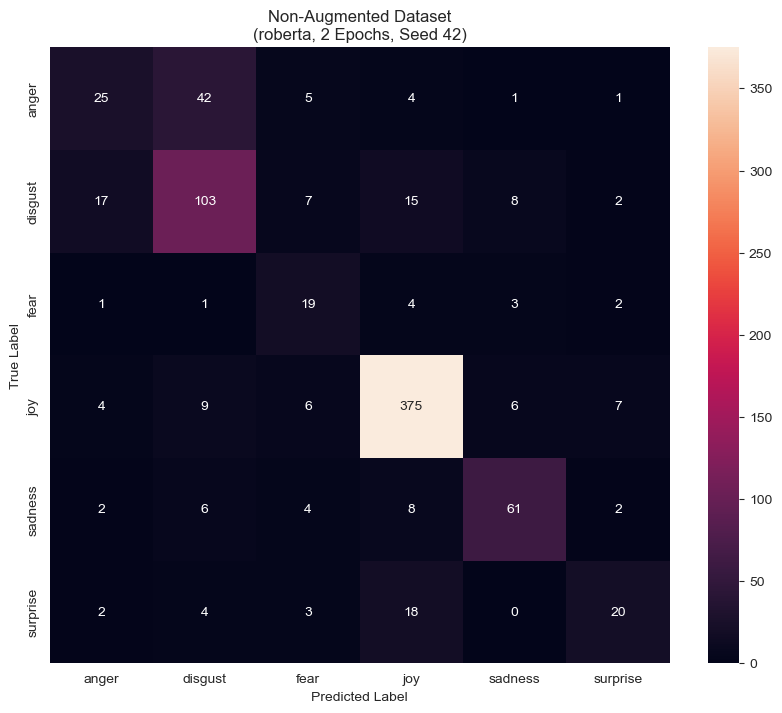

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(df_test["labels"], predictions),
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot=True, fmt="d",
            cmap="rocket")

plt.title(f"Non-Augmented Dataset\n"
          f"({classifier}, {epochs} Epochs, Seed {classifier_random_seed})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

In [19]:
df_test["labels"] = le.inverse_transform(df_test["labels"])
df_test["predict"] = le.inverse_transform(predictions)

In [20]:
df_test[(df_test["labels"] == "anger") 
        & (df_test["predict"] == "disgust")]

,text,labels,predict
5886,Conflict theory is once more implemented in #V...,anger,disgust
4408,Please pray for the #Venezuela people 🙏🏼 looks...,anger,disgust
2809,USER Lies. The small orange penis wants to se...,anger,disgust
1969,This is the point where idiots confuse a thiev...,anger,disgust
6653,USER USER is not wrong in the fact that the en...,anger,disgust
3585,Either the US made many of the blows in the wo...,anger,disgust
888,Suarez at his ugliest best. A real pain in the...,anger,disgust
4965,USER You might want to tag on an addendum to t...,anger,disgust
5041,I'm upset by how many people are now talking a...,anger,disgust
4866,I do not care if you view CNN as faker than a ...,anger,disgust


In [21]:
df_test[df_test["labels"] != df_test["predict"]]

,text,labels,predict
3632,Spending the next 2 weeks traveling the world ...,disgust,joy
576,what a fucking 80mins of tele 😳😂 #GameofThrones,joy,surprise
3637,"So many people on the left, in the centre, and...",sadness,disgust
6014,GOT 2x last night and a first time matinee of ...,sadness,joy
5886,Conflict theory is once more implemented in #V...,anger,disgust
...,...,...,...
4558,Messi showing pure emotion yelling at Vidal to...,surprise,joy
4156,"Well, that could have gone better... But 3-0 ...",fear,joy
3052,I don't wanna be left happy and relieved at th...,disgust,sadness
2017,Now ya all know English teams are shit at #Cha...,anger,disgust


In [22]:
# Remove model from GPU memory
import gc

with torch.no_grad():
    torch.cuda.empty_cache()

del model
gc.collect()

7093